To run a cell, type `Shift` + `Return`. Run the cell below to get started

In [1]:
from workshop_utils import * 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import geopandas as gpd
import shapely
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm_notebook as tqdm
tqdm().pandas();

# Buildings, buildings buildings


Getting the buildings from task https://tasks.hotosm.org/project/4690

```sql
SELECT
  subsaharan_africa.id, 
  geom,
  subsaharan_africa.tags, changeset, updated, valid_until, version, minor_version,
  changesets.id AS c_id, 
  changesets.tags as c_tags,
  changesets.uid,
  changesets.user
  
FROM subsaharan_africa

JOIN changesets on subsaharan_africa.changeset = changesets.id

WHERE   
  element_at(subsaharan_africa.tags, 'building') IS NOT NULL AND ST_WITHIN(
  geom , 
  ST_POLYGON('POLYGON((17.8183 0.0461, 18.9637 0.0461, 18.9637 -0.9686, 17.8183 -0.9686, 17.8183 0.0461))'))

ORDER BY updated
```

In [20]:
building_edits = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/ba10a1bb-3347-4c40-a1ae-2f8ff63f344a/csv')


/www/ba10a1bb-3347-4c40-a1ae-2f8ff63f344a.csv
Creating dataframe... done.  Found 133,927 rows

In [21]:
place = "Mbandaka - Bikoro"

In [23]:
building_edits.head(2)

,id,geom,tags,changeset,updated,valid_until,version,minor_version,c_id,c_tags,uid,user
0,205007052,"POLYGON ((18.2499352 0.0439872, 18.2499358 0.0...",{building=yes},14989051,2013-02-11 01:02:26.000,2018-05-12 17:49:31.000,1,0,14989051,"{comment=Drawing buildings (source=Bing), Mban...",190626,clairedelune
1,205007054,"POLYGON ((18.248523 0.0454874, 18.2485153 0.04...",{building=yes},14989051,2013-02-11 01:02:26.000,NaN,1,0,14989051,"{comment=Drawing buildings (source=Bing), Mban...",190626,clairedelune


In [24]:
#Cast the date as date
building_edits['updated'] = building_edits.updated.progress_apply(pd.Timestamp)
building_edits['date'] = building_edits.updated.progress_apply(pd.Timestamp.date)

In [25]:
gb_date = building_edits.groupby('date').aggregate({
    'c_id':'count',
    'id':'nunique',
    'uid':'nunique'
});
gb_date.head(2)

,c_id,id,uid
date,,,
2013-02-11,34,34,1
2013-02-24,39,39,1


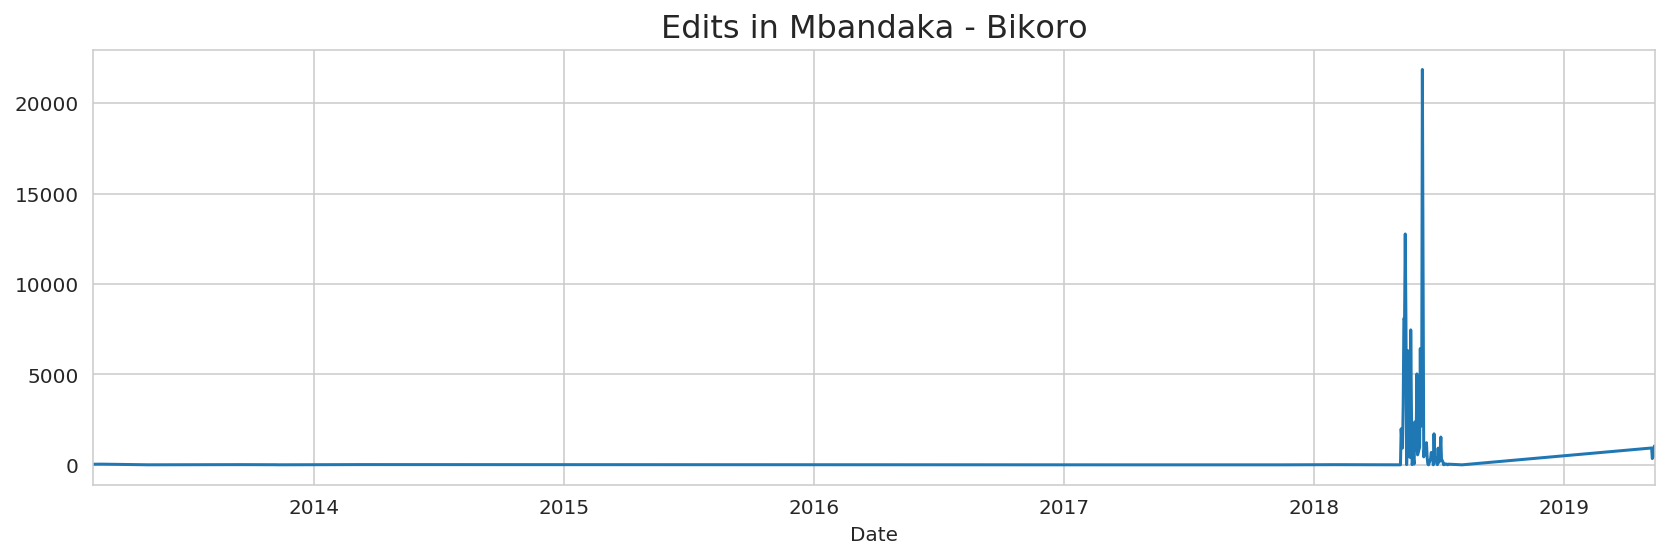

In [26]:
sns.set_style('whitegrid')
ax = gb_date['c_id'].plot(figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Edits in {}".format(place),fontsize=16);

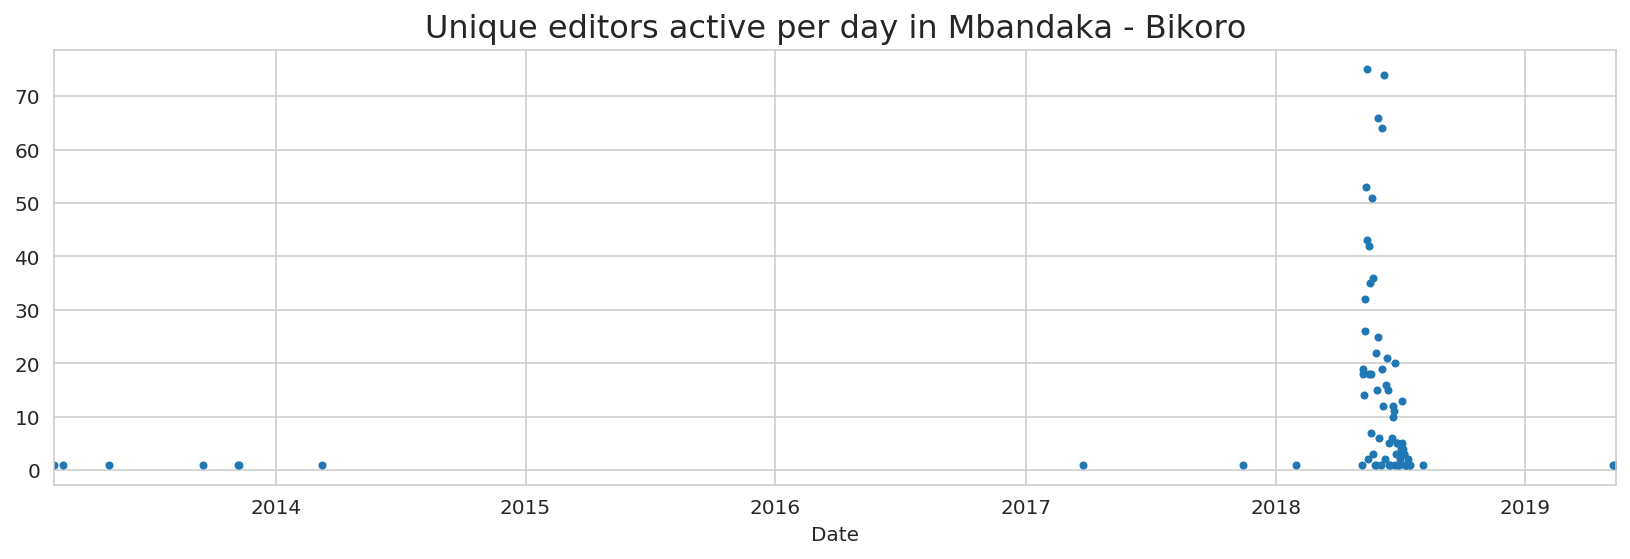

In [27]:
sns.set_style('whitegrid')
ax = gb_date['uid'].plot(style='.', figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Unique editors active per day in {}".format(place),fontsize=16);

In [28]:
from shapely import wkt

In [29]:
building_edits['geom'] = building_edits.geom.progress_apply(wkt.loads) #Makes the geometry an actual object...

In [30]:
objects = gpd.GeoDataFrame(building_edits, geometry='geom')

In [31]:
objects['date'] = objects.updated.apply(lambda x: x.isoformat())

In [32]:
from keplergl import KeplerGl 
map_1 = KeplerGl(height=600)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


In [33]:
map_1

KeplerGl(height=600)

In [37]:
map_1.add_data(data=objects[objects.updated > datetime.datetime(2018,1,1)][['geom','changeset','date','user','version','minor_version']], name='objects')

In [78]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

def make_grid(length=0.1,width=0.1):
    xmin,ymin,xmax,ymax = points.total_bounds

    length = 0.1
    wide = 0.1

    cols = list(np.arange(int(np.floor(xmin)), int(np.ceil(xmax)), wide))
    rows = list(np.arange(int(np.floor(ymin)), int(np.ceil(ymax)), length))
    rows.reverse()

    polygons = []
    ids = []; count=0
    for x in cols:
        for y in rows:
            count = count + 1
            ids.append(count)
            polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]) )

    return gpd.GeoDataFrame({'geometry':polygons, 'PolyID':ids})

In [79]:
grid = make_grid()

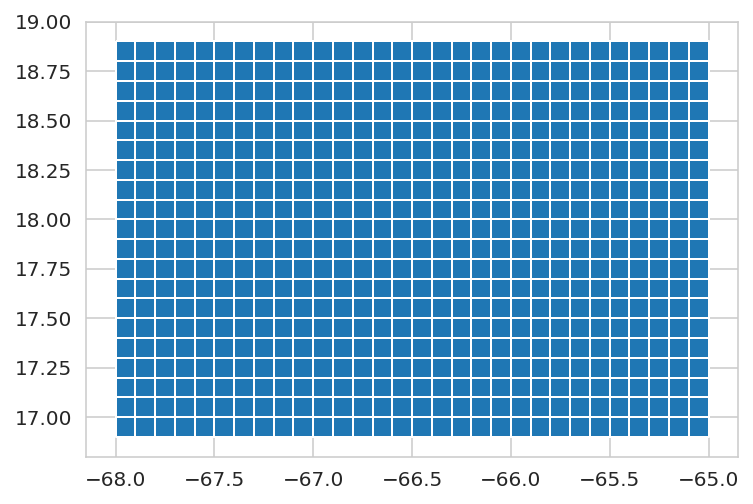

In [80]:
grid.plot()

In [87]:
dfsjoin = gpd.sjoin(grid,points) #Spatial join Points to polygons
dfpivot = pd.pivot_table(dfsjoin,index='PolyID',columns='id',aggfunc={'id':len})
dfpivot.columns = dfpivot.columns.droplevel()

dfpolynew = grid.merge(dfpivot, how='left',on='PolyID')

In [88]:
dfpolynew.head()

,geometry,PolyID,900353,1191518,4430069,5889030,7727664,21652877,21653368,21653667,...,5969324157,5972770387,5972792002,6106367211,6175651620,6192578385,6271952213,6319680655,6416588872,6446619251
0,"POLYGON ((-68 18.90000000000003, -67.900000000...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((-68 18.80000000000003, -67.900000000...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((-68 18.70000000000002, -67.900000000...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((-68 18.60000000000002, -67.900000000...",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((-68 18.50000000000002, -67.900000000...",5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


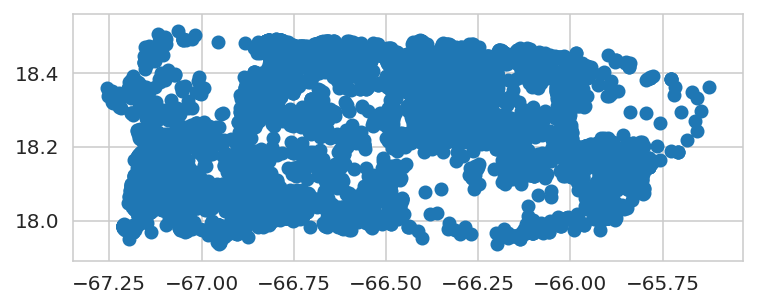

In [65]:
points.plot()